In [332]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from scipy.optimize import curve_fit

from astropy.io import fits
from astropy.wcs import WCS

from photutils.detection import DAOStarFinder
from astropy.stats import mad_std

from astropy.stats import sigma_clipped_stats
from astropy.stats import SigmaClip

from astropy import units as u
from photutils.background import Background2D, MedianBackground
from photutils.aperture import aperture_photometry, CircularAnnulus, CircularAperture

import csv

import astrometry
import pandas as pd
import astropy.units as u

import astropy as ap

solver = astrometry.Solver(
    astrometry.series_5200.index_files(
        cache_directory="astrometry_cache",
        scales={1,3},
    )
)

import logging

from reproject import reproject_interp
from collections import defaultdict
from scipy.ndimage import shift as ndi_shift
from astropy.coordinates import SkyCoord, match_coordinates_sky

astrometry.net/util/fitsbin.c:505:read_chunk: Expected table size (3250334 => 1129 FITS blocks) is not equal to size of table "sweep" (44144640 => 15328 FITS blocks).
INFO:root:loaded 96 index files
astrometry.net/util/fitsbin.c:505:read_chunk: Expected table size (3797452 => 1319 FITS blocks) is not equal to size of table "sweep" (37350720 => 12969 FITS blocks).
astrometry.net/util/fitsbin.c:505:read_chunk: Expected table size (3872556 => 1345 FITS blocks) is not equal to size of table "sweep" (34280640 => 11903 FITS blocks).
astrometry.net/util/fitsbin.c:505:read_chunk: Expected table size (3880526 => 1348 FITS blocks) is not equal to size of table "sweep" (38482560 => 13362 FITS blocks).
astrometry.net/util/fitsbin.c:505:read_chunk: Expected table size (3242442 => 1126 FITS blocks) is not equal to size of table "sweep" (33649920 => 11684 FITS blocks).
astrometry.net/util/fitsbin.c:505:read_chunk: Expected table size (3788051 => 1316 FITS blocks) is not equal to size of table "sweep"

## Test

Filename: 23feb.0001.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     143   (1365, 1365)   float32   


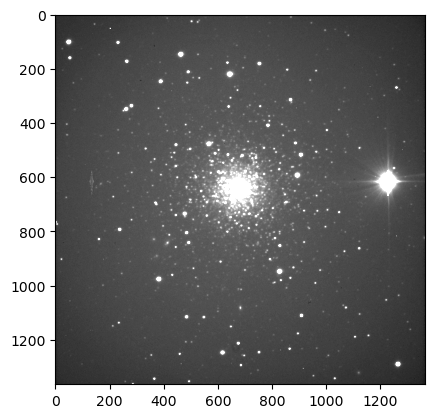

In [334]:
# define the image, open, and read the header information
filename = '23feb.0001.fits'
hdu = fits.open(filename)[0]
image = hdu.data
hdr = hdu.header

# plot the image, with minimum and maximum levels set by percentiles
ax = plt.subplot()
ax.imshow(image,cmap='gray',vmin=150,vmax=500)
fits.info(filename)

## Functions

In [336]:
#defining a function that corrects the bias:
def BiasCorrection(filenum):
    #Defining bias_image
    filename = 'bias.fits'
    hdu = fits.open(filename)[0]
    bias_image = hdu.data
    hdr = hdu.header

    #create a dictionary for the corrected files
    corrected = {}
    
    for i in range(1, filenum+1):
        filename = f'23feb.{i:04d}.fits'
        hdu = fits.open(filename)[0]
        image = hdu.data
        hdr = hdu.header

        #Code from Lab 4
        #get size of image
        h, w = image.shape
        #initialize overscan array
        overscan = []
        
        #calculate mean overscan values
        for j in range(1,h):
            overscan = np.append(overscan,np.mean(image[j,:]))

        #subtract and store in dictionary
        bias = image - bias_image
        filt = hdr.get('FILTER')
        exposure = hdr.get('EXPTIME')
        
        corrected[filename] = {
        'data': bias,
        'filter': filt,
        'exposure': exposure
        }

    #returns the dictionary
    return corrected

In [337]:
#Defining function that flatfields:
def Flatfielding(corrected):
    #create a dictionary of the filters
    flatdict = {
        'Harris-R': 'rflat.fits',
        'Harris-V': 'vflat.fits',
        'Harris-B': 'bflat.fits',
        'Bessell-U': 'uflat.fits',
    }
    #interate across dict
    for file, info in corrected.items():
        data = info['data']
        filt = info['filter']
        #grab flat field fits
        flat = flatdict.get(filt)

        hdu = fits.open(flat)[0]
        flatdata = hdu.data
        
        info['flatdata'] = data / flatdata
    return corrected

In [338]:
#Defining function that finds stars:
import sep
import numpy as np
from astropy.table import Table

def Starfinding(corrected,
                thresh_sigma=30.0,
                min_area=5,
                edge_buffer=10):
    """
    Run SEP on each corrected['flatdata'] image to find stars.

    Parameters
    ----------
    corrected : dict
        { filename: {'flatdata': 2D array, …}, … }
    thresh_sigma : float
        Detection threshold in sigma above local background.
    min_area : int
        Minimum number of connected pixels for a source.
    edge_buffer : int
        Number of pixels to exclude sources too close to the border.

    Returns
    -------
    tables : dict
        { filename: astropy.table.Table of sources }
    """
    tables = {}
    for fname, info in corrected.items():
        data = info['flatdata'].astype(np.float32)
        # 1) Background model + subtraction
        bkg = sep.Background(data)
        data_sub = data - bkg

        # 2) Source extraction
        thresh = thresh_sigma * bkg.globalrms
        objects = sep.extract(data_sub, thresh, minarea=min_area)

        if len(objects) == 0:
            # no detections; return empty table
            tables[fname] = Table(names=('xcenter','ycenter','flux'), dtype=('f8','f8','f8'))
            continue

        # 3) Filter out edge sources
        mask = (
            (objects['x'] > edge_buffer) &
            (objects['x'] < data.shape[1] - edge_buffer) &
            (objects['y'] > edge_buffer) &
            (objects['y'] < data.shape[0] - edge_buffer)
        )
        objs = objects[mask]

        # 4) Build an Astropy Table
        tbl = Table()
        tbl['xcenter'] = objs['x']
        tbl['ycenter'] = objs['y']
        tbl['flux']    = objs['flux']
        # you can add more columns if you like, e.g.:
        # tbl['area']    = objs['npix']
        # tbl['a']       = objs['a']   # semi-major axis
        # tbl['b']       = objs['b']   # semi-minor axis
        # tbl['ellipticity'] = 1 - objs['b']/objs['a']

        tables[fname] = tbl

    return tables


In [339]:
#First attempt at stacking, this one uses Starfinding but does not work
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord, match_coordinates_sky
from scipy.ndimage import shift as ndi_shift
from skimage.registration import phase_cross_correlation
from astropy.io import fits
import numpy as np
from collections import OrderedDict, defaultdict
import warnings

def align_and_stack_corrected(
    corrected,
    filter_list=None,
    max_sep=1.0,
    interp_order=1,
    min_matches=5
):
    """
    Align & stack bias/flat-corrected images, with multiple fallback methods:
      1) star-matching via Starfinding
      2) phase-cross-correlation of the arrays
      3) WCS CRPIX differences

    corrected : dict
      { filename: {'flatdata': 2D array, 'filter': str, …}, … }
    interp_order : int
      interpolation order for ndi_shift (0–5). Try 1 or 0 for sharp stars.
    """
    if filter_list is None:
        filter_list = ['Harris-R','Harris-V','Harris-B','Bessell-U']

    # Run your Starfinding once to get tables { filename → Table }
    star_tables = Starfinding(corrected)

    # Build exposures list
    exposures = []
    for fname, info in corrected.items():
        filt = info['filter']
        if filt not in filter_list:
            continue
        hdr = info.get('header', fits.getheader(fname))
        exposures.append({
            'filename': fname,
            'data':     info['flatdata'],
            'header':   hdr,
            'filter':   filt
        })

    # Group by filter in the given order
    groups = OrderedDict((f, []) for f in filter_list)
    for exp in exposures:
        groups[exp['filter']].append(exp)

    stacked = OrderedDict()
    shifts_dict  = OrderedDict()

    for filt, exps in groups.items():
        if not exps:
            warnings.warn(f"No exposures for filter {filt!r}", UserWarning)
            stacked[filt], shifts_dict[filt] = None, []
            continue

        # Reference image
        ref = exps[0]
        ref_wcs = WCS(ref['header'])
        ref_tbl = star_tables[ref['filename']]
        # adapt to your column names
        x_ref = ref_tbl['xcentroid'] if 'xcentroid' in ref_tbl.colnames else ref_tbl['xcenter']
        y_ref = ref_tbl['ycentroid'] if 'ycentroid' in ref_tbl.colnames else ref_tbl['ycenter']
        ref_coords = SkyCoord.from_pixel(x_ref, y_ref, ref_wcs)

        aligned_imgs = []
        shifts = []

        for exp in exps:
            dx = dy = None

            # 1) Try star‐match
            try:
                tbl = star_tables[exp['filename']]
                x = tbl['xcentroid'] if 'xcentroid' in tbl.colnames else tbl['xcenter']
                y = tbl['ycentroid'] if 'ycentroid' in tbl.colnames else tbl['ycenter']
                wcs = WCS(exp['header'])
                sky = SkyCoord.from_pixel(x, y, wcs)
                idx, sep, _ = match_coordinates_sky(sky, ref_coords)
                mask = sep.arcsec < max_sep
                if mask.sum() < min_matches:
                    raise ValueError("too few stars")

                # compute shift
                ref_pix = np.vstack(ref_wcs.world_to_pixel(ref_coords[idx[mask]])).T
                exp_pix = np.vstack([x[mask], y[mask]]).T
                dx, dy = np.mean(ref_pix - exp_pix, axis=0)

            except Exception:
                # 2) Try phase‐cross‐correlation
                try:
                    shift_yx, _ = phase_cross_correlation(
                        ref['data'], exp['data'], upsample_factor=10
                    )
                    dy, dx = shift_yx  # note: returns (shift_y, shift_x)
                except Exception:
                    # 3) Fallback to WCS
                    warnings.warn(
                        f"{exp['filename']}: star+PCC failed, using CRPIX shift",
                        UserWarning
                    )
                    e_wcs = WCS(exp['header'])
                    dx, dy = (ref_wcs.wcs.crpix - e_wcs.wcs.crpix)

            # Apply and record
            shifts.append((float(dx), float(dy)))
            shifted = ndi_shift(
                exp['data'],
                shift=(float(dy), float(dx)),
                order=interp_order,
                mode='constant',
                cval=np.nan
            )
            aligned_imgs.append(shifted)

        # Stack
        stacked[filt] = np.nanmean(aligned_imgs, axis=0)
        shifts_dict[filt] = shifts

    return stacked, shifts_dict


In [340]:
from skimage.registration import phase_cross_correlation
from scipy.ndimage import shift as ndi_shift
import numpy as np
from collections import OrderedDict, defaultdict
import warnings
#Second attempt at a function for stacking images, this one works
def align_and_stack_xcorr(
    corrected,
    filter_list=None,
    interp_order=0,
    upsample_factor=20,
    combine='median'
):
    """
    Align & stack your flat‐corrected images by FFT cross‐correlation.

    Parameters
    ----------
    corrected : dict
        { filename: {'flatdata': 2D array, 'filter': str, [, 'header':…]}, … }
    filter_list : list of str
        Filters to include. Default: the four you listed.
    interp_order : int
        Order for ndi_shift (0=nearest, 1=bilinear).  
    upsample_factor : int
        Subpixel precision for phase_cross_correlation.
    combine : str
        'median' or 'mean' for stacking.

    Returns
    -------
    stacked : OrderedDict
        { filter: 2D array of the aligned+stacked image }
    shifts : OrderedDict
        { filter: [ (dx,dy), … ] for each exposure }
    """
    if filter_list is None:
        filter_list = ['Harris-R','Harris-V','Harris-B','Bessell-U']

    # Build list of exposures per filter
    groups = OrderedDict((f, []) for f in filter_list)
    for fname, info in corrected.items():
        f = info['filter']
        if f in groups:
            groups[f].append(info['flatdata'])

    stacked = OrderedDict()
    shifts = OrderedDict()

    for filt, imgs in groups.items():
        if not imgs:
            warnings.warn(f"No frames for filter {filt!r}", UserWarning)
            stacked[filt], shifts[filt] = None, []
            continue

        ref = imgs[0]
        aligned = [ref]
        this_shifts = [(0.0, 0.0)]  # reference has zero shift

        for img in imgs[1:]:
            # compute shift of img to ref
            shift_yx, error, diffphase = phase_cross_correlation(
                ref, img,
                upsample_factor=upsample_factor
            )
            dy, dx = shift_yx

            # apply shift with nearest/bilinear interp
            img_s = ndi_shift(img, shift=(dy, dx),
                              order=interp_order,
                              mode='constant', cval=np.nan)

            aligned.append(img_s)
            this_shifts.append((float(dx), float(dy)))

        # stack
        stack_array = np.stack(aligned, axis=0)
        if combine == 'median':
            result = np.nanmedian(stack_array, axis=0)
        else:
            result = np.nanmean(stack_array, axis=0)

        stacked[filt] = result
        shifts[filt]  = this_shifts

    return stacked, shifts


In [341]:
corrected = BiasCorrection(56)
corrected = Flatfielding(corrected)
#corrected = Background(corrected)
tables = Starfinding(corrected)


167


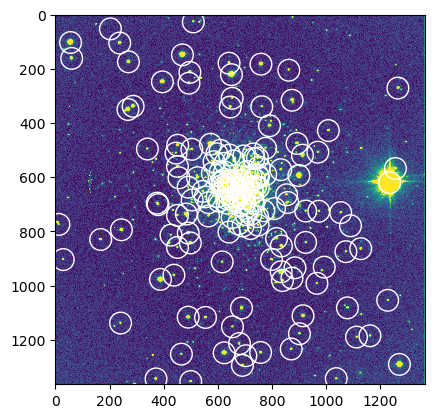

In [342]:
image = corrected['23feb.0002.fits']['flatdata']

tbl = tables['23feb.0002.fits']

x = tbl['xcenter'].value    
y = tbl['ycenter'].value    
print(len(x))
# combine into a 2×N array of (x,y) pairs
positions = np.transpose((x, y))   
plt.imshow(image,interpolation='nearest',vmin=np.percentile(image,2), vmax=np.percentile(image,98))
aperture = CircularAperture(positions, r=40)
ann_patches = aperture.plot(color='white',lw=1)

     xcenter           ycenter           flux     
----------------- ----------------- --------------
503.4947869869565 26.30204393607437 6203.365234375
170


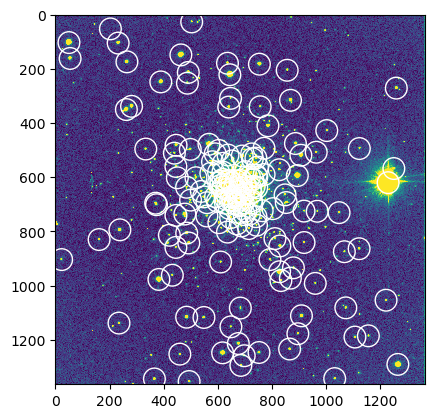

In [343]:
image = corrected['23feb.0001.fits']['flatdata']

tbl = tables['23feb.0001.fits']
print(tbl[0])
x = tbl['xcenter'].value    
y = tbl['ycenter'].value    
print(len(x))
# combine into a 2×N array of (x,y) pairs
positions = np.transpose((x, y))   
plt.imshow(image,interpolation='nearest',vmin=np.percentile(image,2), vmax=np.percentile(image,98))
aperture = CircularAperture(positions, r=40)
ann_patches = aperture.plot(color='white',lw=1)

In [344]:
stacked, shifts = align_and_stack_xcorr(
    corrected,
    filter_list=['Harris-R','Harris-V','Harris-B','Bessell-U'],
    interp_order=0,        # bilinear: smoother than nearest but sharper than cubic
    upsample_factor=200,    # subpixel precision of 1/20th pixel
    combine='median'       # median‐stack to reject any remaining misalignments
)
print(stacked)

OrderedDict({'Harris-R': array([[259.81967, 258.1181 , 250.99844, ..., 245.40547, 245.06396,
        245.01392],
       [269.05847, 264.21027, 241.46765, ..., 311.06256, 310.68985,
        311.40024],
       [277.938  , 260.76123, 265.9863 , ..., 312.3368 , 312.38782,
        312.7741 ],
       ...,
       [697.78217, 702.9591 , 710.8971 , ..., 554.11487, 553.3473 ,
        554.0535 ],
       [702.04376, 708.7973 , 694.11804, ..., 547.66675, 547.505  ,
        547.9392 ],
       [688.24536, 712.89374, 690.05884, ..., 505.9264 , 505.8543 ,
        506.3476 ]], dtype=float32), 'Harris-V': array([[556.58136, 544.00665, 556.5114 , ..., 368.3829 , 390.68762,
        390.6534 ],
       [538.71594, 533.44965, 542.26154, ..., 406.01645, 428.68634,
        428.70905],
       [539.3496 , 558.09924, 553.13544, ..., 416.47992, 439.2092 ,
        439.42957],
       ...,
       [241.82541, 229.1849 , 245.81369, ..., 262.3728 , 261.2769 ,
        261.9775 ],
       [239.03705, 245.60107, 252.34503, .

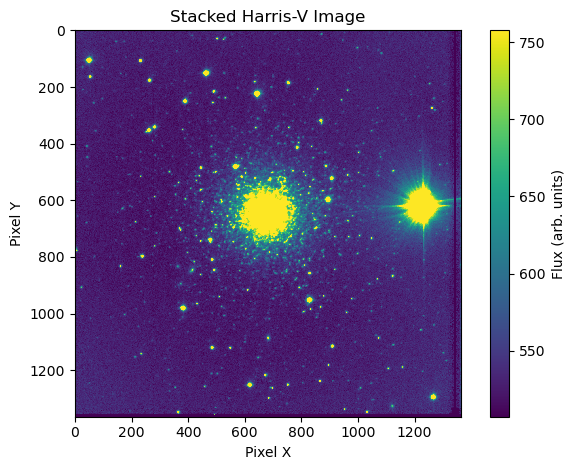

In [345]:
# pick your filter
filt = 'Harris-V'

# fetch the stacked array
img = stacked[filt]

# plot it
plt.figure()
plt.imshow(img,interpolation='nearest',vmin=np.percentile(img,2), vmax=np.percentile(img,98))      # default colormap
plt.title(f"Stacked {filt} Image")
plt.xlabel("Pixel X")
plt.ylabel("Pixel Y")
plt.colorbar(label="Flux (arb. units)")
plt.tight_layout()
plt.show()

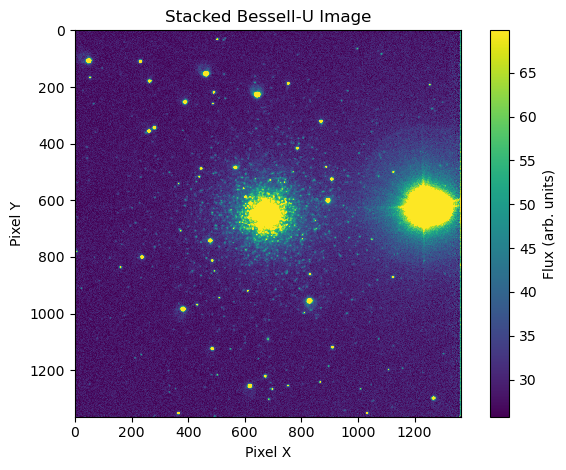

In [346]:
# pick your filter
filt = 'Bessell-U'

# fetch the stacked array
img = stacked[filt]

# plot it
plt.figure()
plt.imshow(img,interpolation='nearest',vmin=np.percentile(img,2), vmax=np.percentile(img,98))      # default colormap
plt.title(f"Stacked {filt} Image")
plt.xlabel("Pixel X")
plt.ylabel("Pixel Y")
plt.colorbar(label="Flux (arb. units)")
plt.tight_layout()
plt.show()

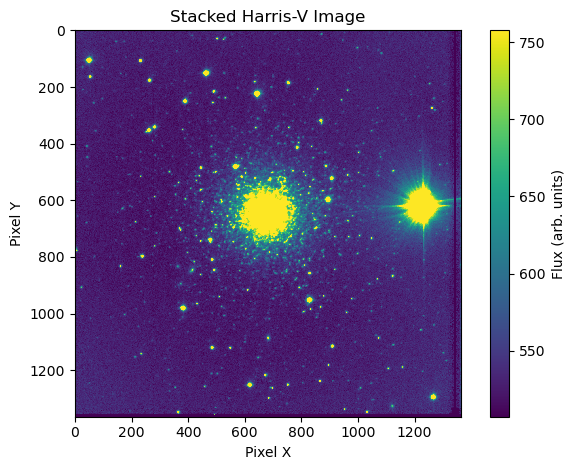

In [347]:
# pick your filter
filt = 'Harris-V'

# fetch the stacked array
img = stacked[filt]

# plot it
plt.figure()
plt.imshow(img,interpolation='nearest',vmin=np.percentile(img,2), vmax=np.percentile(img,98))      # default colormap
plt.title(f"Stacked {filt} Image")
plt.xlabel("Pixel X")
plt.ylabel("Pixel Y")
plt.colorbar(label="Flux (arb. units)")
plt.tight_layout()
plt.show()

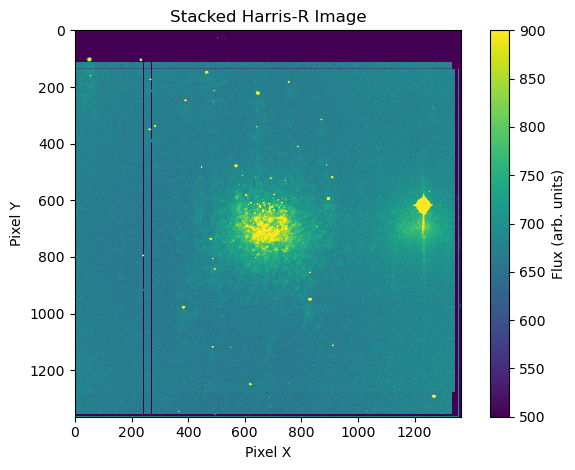

In [348]:
# pick your filter
filt = 'Harris-R'

# fetch the stacked array
img = stacked[filt]

# plot it
plt.figure()
plt.imshow(img,interpolation='nearest',vmin=500, vmax=900)      # default colormap
plt.title(f"Stacked {filt} Image")
plt.xlabel("Pixel X")
plt.ylabel("Pixel Y")
plt.colorbar(label="Flux (arb. units)")
plt.tight_layout()
plt.show()